In [1]:
# Figure 1 

setwd('/Users/ibishara/Desktop/FELINE_C1/')

# packages
library(data.table)
library(tidyverse)
library(ggridges)
library(ggpubr)
library(qs)
library(factoextra)


# data
# meta_raw <- read.table('raw/FELINE_C1_raw_singler_metadata.txt', sep='\t') # combined raw metadata of FELINE-C1. Generated by IB. Not used in this analysis. 

# hpca_anno_raw <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/raw/SingleR/hpca/FELINE_C1_hpca_singleR_annotations.txt', sep='auto'))[, -1] # hpca singleR annotations FELINE-C1
# metadata_post_filter <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/post-filter/FEL001046_scRNA.metadata_JF.txt', sep='auto')) # Jinfeng's high quality metadata 
meta_sub_LQ <- fread('metadata_subsample_LQ.txt', sep='\t', data.table=F) # low quality subsample metadata
meta_sub_HQ <- fread('metadata_subsample_HQ.txt', sep='\t', data.table=F) # high quality subsample metadata

meta_sub <- bind_rows(meta_sub_HQ[, c('Cell', 'Percent.Mitochondria', 'nCount_RNA', 'nFeature_RNA', 'Annotation', 'Celltype', 'hpca', 'Lineage')], 
meta_sub_LQ[, c('Cell', 'nCount_RNA', 'nFeature_RNA', 'Percent.Mitochondria', 'hpca', 'Lineage') ])
# Edit to block back identification to patients 

dim(meta_sub_HQ)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

qs v0.23.6.

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



[1] 35000    10

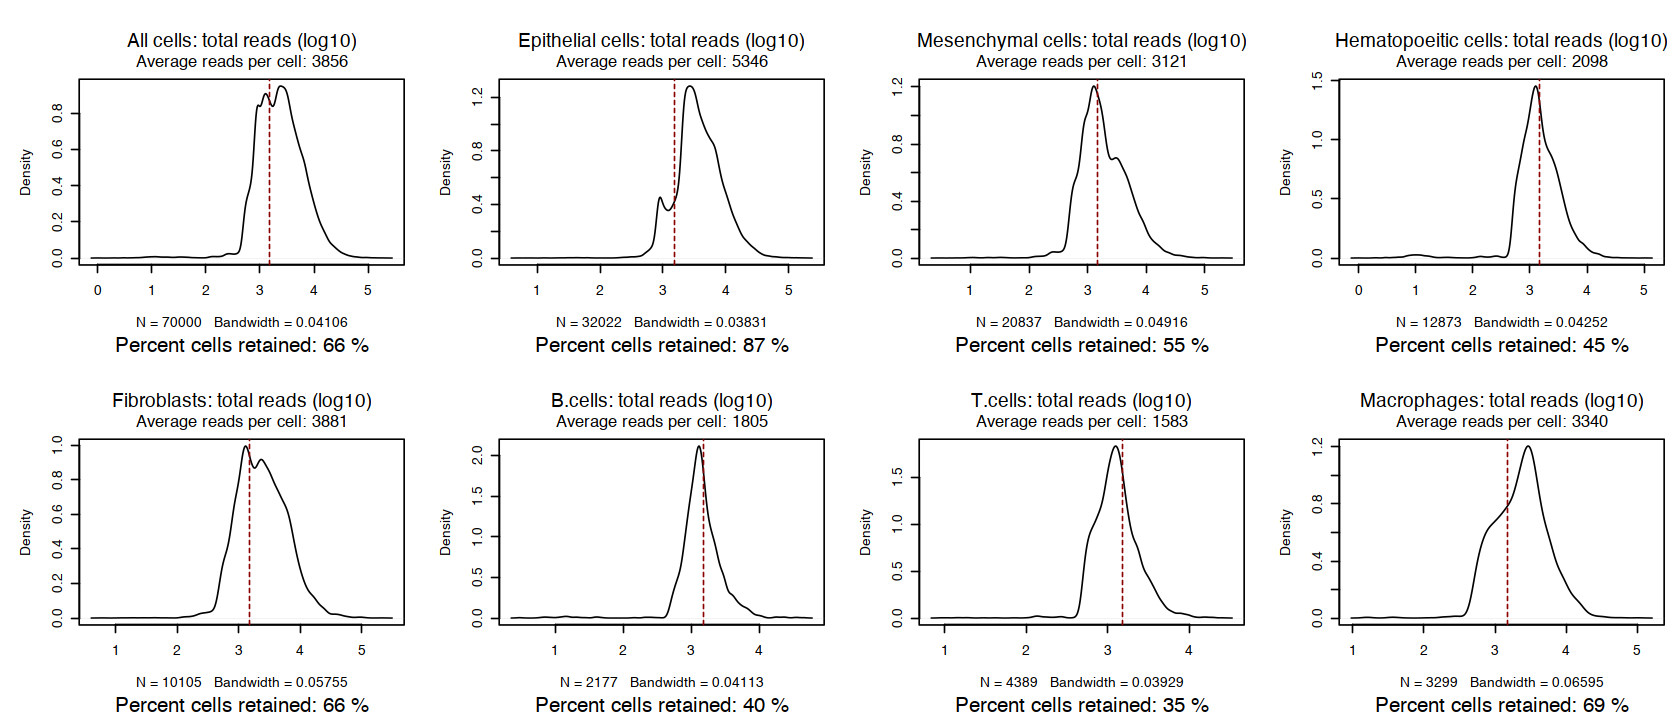

In [303]:

options(repr.plot.width=14, repr.plot.height=6)

## indexing 
# Lineage
epi.ind <- which(meta_sub$Lineage == "Epithelial_cells")
mes.ind <- which(meta_sub$Lineage == "Mesenchymal_cells")
hem.ind <- which(meta_sub$Lineage == "Hematopoeitic_cells")

# cell type
tcell.ind <- which( meta_sub$hpca == "T_cells" )
bcell.ind <- which( meta_sub$hpca == "B_cell" )
macro.ind <- which( meta_sub$hpca == "Macrophage")
fibro.ind <- which( meta_sub$hpca == "Fibroblasts")
endo.ind <- which( meta_sub$hpca == "Endothelial_cells")
bcell.ind <- which( meta_sub$hpca == "B_cell")



## setting cut-offs
## JF's cut-off for FELINE_C1: > 2000 UMI. 500 - 7000 genes 
nCount_RNA_cutoff <- 1500
new.nCount_RNA_cutoff <- 800
Expressed.Features_cutoff.min <- 500
Expressed.Features_cutoff.max <- 7000



all.retained <- length(which(meta_sub$nCount_RNA > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA )
epi.retained <- length(which(meta_sub$nCount_RNA[epi.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[epi.ind] )
mes.retained <- length(which(meta_sub$nCount_RNA[mes.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[mes.ind] )
hem.retained <- length(which(meta_sub$nCount_RNA[hem.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[hem.ind] )

tcell.retained <- length(which(meta_sub$nCount_RNA[tcell.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[tcell.ind] )
macro.retained <- length(which(meta_sub$nCount_RNA[macro.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[macro.ind] )
fibro.retained <- length(which(meta_sub$nCount_RNA[fibro.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[fibro.ind] )
endo.retained <- length(which(meta_sub$nCount_RNA[endo.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[endo.ind] )
bcell.retained <- length(which(meta_sub$nCount_RNA[bcell.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[bcell.ind] )


# pre.retained.epi <- length(which(meta_sub$nCount_RNA[epi.ind] > nCount_RNA_cutoff))
# post.retained.epi <- length(which(meta_sub$nCount_RNA[epi.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[epi.ind] > new.nCount_RNA_cutoff))

# pre.retained.tcell <- length(which(meta_sub$nCount_RNA[tcell.ind] > nCount_RNA_cutoff))
# post.retained.tcell <- length(which(meta_sub$nCount_RNA[tcell.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[tcell.ind] > new.nCount_RNA_cutoff))

# pre.retained.macro <- length(which(meta_sub$nCount_RNA[macro.ind] > nCount_RNA_cutoff))
# post.retained.macro <- length(which(meta_sub$nCount_RNA[macro.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[macro.ind] > new.nCount_RNA_cutoff))

# pre.retained.fibro <- length(which(meta_sub$nCount_RNA[fibro.ind] > nCount_RNA_cutoff))
# post.retained.fibro <- length(which(meta_sub$nCount_RNA[fibro.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[fibro.ind] > new.nCount_RNA_cutoff))
## Plot number of reads and genes by Cell type. Epithelial cells are used as a reference 

title.size <- 1.4
lab.size <- 1.0
sub.size <- 1.4

par(mfrow=c(2,4), mar=c(6,5,5,1))


plot(main = "All cells: total reads (log10)", density(log10(meta_sub$nCount_RNA)), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*all.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA)) ),)  # subtitle

plot(main = "Epithelial cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[epi.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*epi.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[epi.ind])) ),)  # subtitle

plot(main = "Mesenchymal cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[mes.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*mes.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[mes.ind])) ),)  # subtitle

plot(main = "Hematopoeitic cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[hem.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*hem.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[hem.ind])) ),)  # subtitle

plot(main = "Fibroblasts: total reads (log10)", density(log10(meta_sub$nCount_RNA[fibro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*fibro.retained ),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[fibro.ind])) ),)  # subtitle

plot(main = "B.cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[bcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*bcell.retained ),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[bcell.ind])) ),)  # subtitle

plot(main = "T.cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[tcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*tcell.retained ),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[tcell.ind])) ),)  # subtitle

plot(main = "Macrophages: total reads (log10)", density(log10(meta_sub$nCount_RNA[macro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*macro.retained ),'%' ),)  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[macro.ind])) ),)  # subtitle



## Add mean annotations 




In [37]:
unique(meta_sub[["HQ_LQ_annotation"]])
unique(meta_sub[ mes.ind,]$HQ_LQ_annotation )
unique(meta_sub[ epi.ind,]$HQ_LQ_annotation )

[1] "Fibroblasts"             "Cancer cells"           
 [3] "Endothelial cells"       "Adipocytes"             
 [5] "Normal epithelial cells" "Pericytes"              
 [7] "T cells"                 "Macrophages"            
 [9] "B cells"                 "iPS_cells"              
[11] "Osteoblasts"             "Neutrophils"            
[13] "Hepatocytes"             "Embryonic_stem_cells"   
[15] "DC"                      "NK_cell"                
[17] "Platelets"               "Tissue_stem_cells"      
[19] "Gametocytes"             "Epithelial_cells"       
[21] "Smooth_muscle_cells"     "Astrocyte"              
[23] "HSC_-G-CSF"              "Erythroblast"           
[25] "Chondrocytes"            "Neurons"                
[27] "Keratinocytes"           "Neuroepithelial_cell"   
[29] "Monocyte"                "MSC"                    
[31] "HSC_CD34+"               "CMP"                    
[33] "Pre-B_cell_CD34-"        "BM"                     
[35] "Pro-B_cell_CD34+"        "MEP"                    
[37] "Myelocyte"               "Pro-Myelocyte"          
[39] "BM_&_Prog."

[1] "Fibroblasts"         "Endothelial cells"   "Adipocytes"         
[4] "Pericytes"           "Osteoblasts"         "Smooth_muscle_cells"
[7] "Chondrocytes"

[1] "Cancer cells"            "Normal epithelial cells"
[3] "Epithelial_cells"

In [5]:
# Figure 2
setwd('/Users/ibishara/Desktop/FELINE_C1/')

# packages
library(data.table)
library(ggridges)
library(ggpubr)
library(stringr)

# data
# all.perf1 <- paste('non-binary/', list.files(path = "/Users/ibishara/Desktop/FELINE_C1/SCN_Performance_summary_non-binary_Lineage.txt", pattern = "SCNPerformance_*", recursive = TRUE), sep='') # create a list of raw count tables from all batches
# all.perf2 <- paste('floor/', list.files(path = "/Users/ibishara/Desktop/FELINE_C1/SCN/floor/", pattern = "Performance_*", recursive = TRUE), sep='') # create a list of raw count tables from all batches
# all.perf <- c(all.perf1, all.perf2)
# all.perf

all.perf <- list.files(path = "/Users/ibishara/Desktop/FELINE_C1/", pattern = "SCN_Performance*", recursive = FALSE)  # create a list of raw count tables from all batches
perf.list.SCN <- lapply( all.perf, FUN = function(x) {fread(x, sep='auto')})
perf.SCN <- as.data.frame(do.call(rbind, perf.list.SCN))  #join list of tables 


all.perf <- list.files(path = "/Users/ibishara/Desktop/FELINE_C1/", pattern = "SR_Performance*", recursive = FALSE)  # create a list of raw count tables from all batches
perf.list.SR <- lapply( all.perf, FUN = function(x) {fread(x, sep='auto')})
perf.SR <- as.data.frame(do.call(rbind, perf.list.SR))  #join list of tables 

### deployment script
# SCN_Performance_summary_non_binary_Lineage <- fread("/Users/ibishara/Desktop/FELINE_C1/SCN_Performance_summary_non-binary_Lineage.txt", sep='auto')
# SCN_Performance_summary_floor_Lineage <- fread("/Users/ibishara/Desktop/FELINE_C1/SCN_Performance_summary_floor_Lineage.txt", sep='auto')

###

# distribution clean-up
# table_type = reads, genes
# method = floor, non-binary

dist.clean <- function(table_type, method){
        # dist <- fread(paste('SCN_', table_type, '_distribution_', method, '.txt' , sep=''), sep = '\t') # read distribution table 
            if(method == 'floor') {dist <- fread(paste('SCN_', table_type, '_distribution_reads_', method, '_Lineage.txt' , sep=''), sep = '\t') # read distribution table 
            } else if (method == 'poisson'){
            dist <- fread(paste('SCN_', table_type, '_distribution_', method, '.txt' , sep=''), sep = '\t') }# read distribution table 

            ##
            # data clean-up
            dist$V1 <- NULL
            dist <- as.data.frame(t(dist))
            colnames(dist) <- dist[1,]
            dist <- dist[-1,]
            dist <- melt(dist)
        }
# dist.reads_floor <- dist.clean('reads', 'floor')
# dist.genes_floor <- dist.clean('genes', 'floor')
dist.reads_poisson <- dist.clean('reads', 'poisson')
dist.genes_poisson <- dist.clean('genes', 'poisson')
# dist.reads_nonbin <- dist.clean('reads', 'non-binary')
# dist.genes_nonbin <- dist.clean('genes', 'non-binary')

# Calculates mean and median for plot annotations 
summ <- function(x) c(Mean = mean(x), median = median(x))
summ.clean <- function(mat) {
    stats <- aggregate(value ~  variable, mat, summ, simplify = TRUE)
    stats <- cbind(stats[1], round(stats[[2]]))
    return(stats)
}

stat.reads_poisson <- summ.clean(dist.reads_poisson)
stat.genes_poisson <- summ.clean(dist.genes_poisson )
# stat.reads_floor <- summ.clean(dist.reads_floor)
# stat.genes_floor <- summ.clean(dist.genes_floor )
# stat.reads_nonbin <- summ.clean(dist.reads_nonbin)
# stat.genes_nonbin <- summ.clean(dist.genes_nonbin)


Warning message in fread(x, sep = "auto"):
“Detected 10 column names but the data has 11 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread(x, sep = "auto"):
“Detected 10 column names but the data has 11 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread(x, sep = "auto"):
“Detected 8 column names but the data has 9 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write c

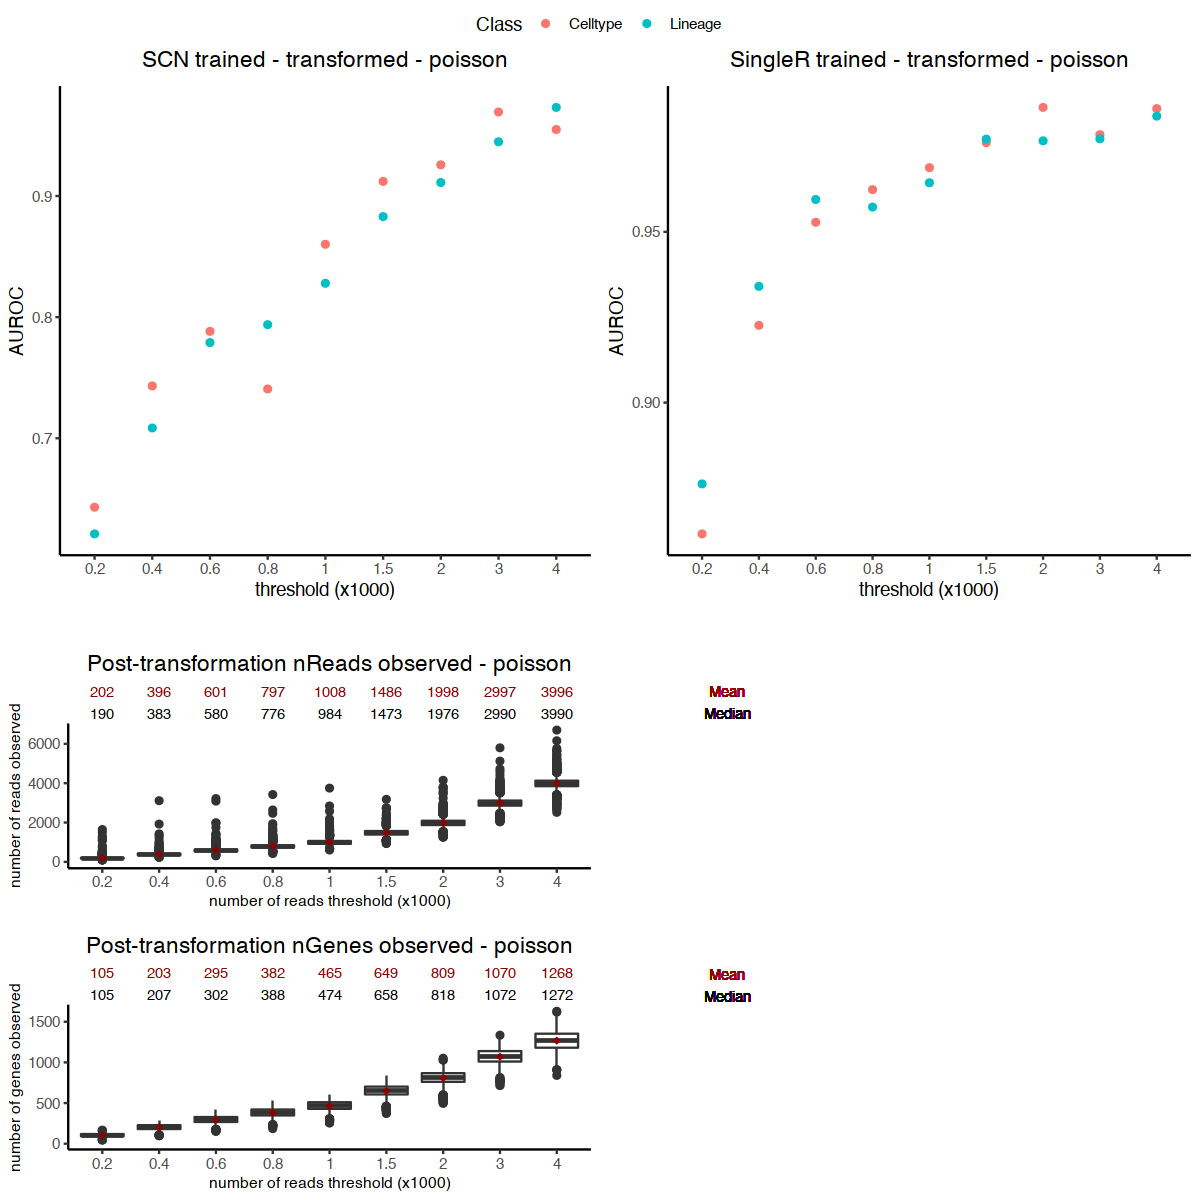

In [6]:

options(repr.plot.width=10, repr.plot.height=10)


# train = 'SCN', 'SR'
# method = 'floor', 'non-binary'
# function plots the AUC at different thresholds of a 'train' algorithm and transformed by 'method'
AUCplot <- function(train, method) {
    if (train == 'SCN'){ 
        train = perf.SCN
        train.name <- 'SCN trained'

    } else if(train == 'SR') {
        train = perf.SR
        train.name <- 'SingleR trained'
        }

    # AUC plot    
    ggplot(train[train$method == method,], aes(as.factor(threshold), as.numeric(AUC_pROC)  )) + 
                geom_point(aes(color = as.factor(class))) + 
                ggtitle(paste(train.name, "transformed", method, sep =' - ')) +
                xlab("threshold (x1000)") + ylab("AUROC")+ labs(color='Class')  +
                theme_classic() + 
                theme(plot.title = element_text(vjust = 2, hjust = 0.5)) # center plot title

}

mean.v = -15
median.v = -13

# show reads and genes distribution, mean and median 
statplot <- function(method){
    if (method == 'floor'){
        table_type <- 'reads'
        dist.reads.data <- dist.reads_floor
        dist.genes.data <- dist.genes_floor
        stats.reads.data <- stat.reads_floor
        stats.genes.data <- stat.genes_floor

        } else if (method == 'poisson'){
        table_type <- 'reads'
        dist.reads.data <- dist.reads_poisson
        dist.genes.data <- dist.genes_poisson
        stats.reads.data <- stat.reads_poisson
        stats.genes.data <- stat.genes_poisson


        } else if (method == 'non-binary'){
        table_type <- 'genes'
        dist.reads.data <- dist.reads_nonbin
        dist.genes.data <- dist.genes_nonbin
        stats.reads.data <- stat.reads_nonbin
        stats.genes.data <- stat.genes_nonbin
        }
    # reads distribution plot 
    plot1 <- ggplot(dist.reads.data, aes(as.factor(variable), value)) + 
                geom_boxplot() + 
                stat_summary(fun= mean, colour="darkred", geom="point", shape=18, size=2, show.legend=FALSE) + # mean
                geom_text(data = stats.reads.data, aes(label = Mean, y =  10), vjust= mean.v, size = 3, colour="darkred") +  # mean annotations
                geom_text(data = stats.reads.data, aes(label = median, y =  10), vjust= median.v, size = 3, colour="black") +  # median annotations 
                geom_text(x=12, y = mean.v, label="Mean", colour="darkred", size = 3, vjust = mean.v ) +  # mean label
                geom_text(x=12, y = median.v, label="Median", colour="black", size = 3, vjust = median.v) +  # median label

                ggtitle(paste("Post-transformation nReads observed -", method)) +
                xlab(paste('number of', table_type, 'threshold (x1000)'))  + ylab("number of reads observed") + 
                theme_classic() +
                theme(plot.title = element_text(vjust = 9, hjust = 0.5), # title centered & up to accomodate stats annotations
                    axis.title=element_text(size= 9,face="bold")) + # adjust axis label sizes
                coord_cartesian(clip = "off")

    # genes distribution plot 
    plot2 <- ggplot(dist.genes.data, aes(as.factor(variable), value)) + 
            geom_boxplot() + 
            stat_summary(fun= mean, colour="darkred", geom="point", shape=18, size=2, show.legend=FALSE) + # mean
            geom_text(data = stats.genes.data, aes(label = Mean, y =  10), vjust= mean.v, size = 3, colour="darkred") +  # mean annotations 
            geom_text(data = stats.genes.data, aes(label = median, y =  10), vjust= median.v, size = 3, colour="black") +  # median annotations 
            geom_text(x=12, y = mean.v, label="Mean", colour="darkred", size = 3, vjust = mean.v ) +  # mean label
            geom_text(x=12, y = median.v, label="Median", colour="black", size = 3, vjust = median.v) +  # median label
            ggtitle(paste("Post-transformation nGenes observed -", method)) +
            xlab(paste('number of', table_type, 'threshold (x1000)')) + ylab("number of genes observed") + 
            theme_classic() +
            theme(plot.title = element_text(vjust = 9, hjust = 0.5), # title centered & up to accomodate stats annotations
                axis.title=element_text(size= 9,face="bold")) + # adjust axis label sizes
            coord_cartesian(clip = "off")

    spacer <- NULL
    ggarrange(grobs = spacer, plot1, spacer, plot2, ncol = 1, nrow = 4, heights=c(20, 100, 20, 100), widths = c(200), legend ='top') 
}

# summary plots
plot1 <- AUCplot('SCN', 'poisson')
plot2 <- AUCplot('SR', 'poisson')
plot3 <- statplot('poisson')


# plot3 <- plotf('SCN', 'non-binary')
# plot4 <- plotf('SR', 'non-binary')

# pdf('performance_perf.SCNary_400_400cells.pdf')
spacer <- NULL
ggarrange(grobs = plot1, plot2, spacer, spacer, plot3, ncol = 2, nrow = 3, heights=c(400, 20, 400), widths = c(200,  200), common.legend = TRUE)

#dev.off()



In [19]:
# Figure 3

setwd('/Users/ibishara/Desktop/FELINE_C1/')

# packages
library(data.table)
library(tidyverse)
library(ggridges)
library(ggpubr)
library(qs)
library(factoextra)


# data
# meta_raw <- read.table('raw/FELINE_C1_raw_singler_metadata.txt', sep='\t') # combined raw metadata of FELINE-C1. Generated by IB. Not used in this analysis. 

# hpca_anno_raw <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/raw/SingleR/hpca/FELINE_C1_hpca_singleR_annotations.txt', sep='auto'))[, -1] # hpca singleR annotations FELINE-C1
# metadata_post_filter <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/post-filter/FEL001046_scRNA.metadata_JF.txt', sep='auto')) # Jinfeng's high quality metadata 
meta_sub_LQ <- fread('metadata_subsample_LQ.txt', sep='\t', data.table=F) # low quality subsample metadata
meta_sub_HQ <- fread('metadata_subsample_HQ.txt', sep='\t', data.table=F) # high quality subsample metadata

meta_sub <- bind_rows(meta_sub_HQ[, c('Cell', 'Percent.Mitochondria', 'nCount_RNA', 'nFeature_RNA', 'Annotation', 'Celltype', 'hpca', 'Lineage')], 
meta_sub_LQ[, c('Cell', 'nCount_RNA', 'nFeature_RNA', 'Percent.Mitochondria', 'hpca', 'Lineage') ])
# Edit to block back identification to patients 

## indexing 
# Lineage
epi.ind <- which(meta_sub$Lineage == "Epithelial_cells")
mes.ind <- which(meta_sub$Lineage == "Mesenchymal_cells")
hem.ind <- which(meta_sub$Lineage == "Hematopoeitic_cells")

# cell type
tcell.ind <- which( meta_sub$hpca == "T_cells" )
bcell.ind <- which( meta_sub$hpca == "B_cell" )
macro.ind <- which( meta_sub$hpca == "Macrophage")
fibro.ind <- which( meta_sub$hpca == "Fibroblasts")
endo.ind <- which( meta_sub$hpca == "Endothelial_cells")
bcell.ind <- which( meta_sub$hpca == "B_cell")



## setting cut-offs
## JF's cut-off for FELINE_C1: > 2000 UMI. 500 - 7000 genes 
nCount_RNA_cutoff <- 1500
new.nCount_RNA_cutoff <- 800
Expressed.Features_cutoff.min <- 500
Expressed.Features_cutoff.max <- 7000



# all.retained <- length(which(meta_sub$nCount_RNA < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA )
# epi.retained <- length(which(meta_sub$nCount_RNA[epi.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[epi.ind] )
# mes.retained <- length(which(meta_sub$nCount_RNA[mes.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[mes.ind] )
# hem.retained <- length(which(meta_sub$nCount_RNA[hem.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[hem.ind] )

# tcell.retained <- length(which(meta_sub$nCount_RNA[tcell.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[tcell.ind] )
# macro.retained <- length(which(meta_sub$nCount_RNA[macro.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[macro.ind] )
# fibro.retained <- length(which(meta_sub$nCount_RNA[fibro.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[fibro.ind] )
# endo.retained <- length(which(meta_sub$nCount_RNA[endo.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[endo.ind] )
# bcell.retained <- length(which(meta_sub$nCount_RNA[bcell.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[bcell.ind] )


pre.retained.all <- length(which(meta_sub$nCount_RNA > nCount_RNA_cutoff))
post.retained.all <- length(which(meta_sub$nCount_RNA < nCount_RNA_cutoff & meta_sub$nCount_RNA > new.nCount_RNA_cutoff))

pre.retained.epi <- length(which(meta_sub$nCount_RNA[epi.ind] > nCount_RNA_cutoff))
post.retained.epi <- length(which(meta_sub$nCount_RNA[epi.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[epi.ind] > new.nCount_RNA_cutoff))

pre.retained.mes <- length(which(meta_sub$nCount_RNA[mes.ind] > nCount_RNA_cutoff))
post.retained.mes <- length(which(meta_sub$nCount_RNA[mes.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[mes.ind] > new.nCount_RNA_cutoff))

pre.retained.hem <- length(which(meta_sub$nCount_RNA[hem.ind] > nCount_RNA_cutoff))
post.retained.hem <- length(which(meta_sub$nCount_RNA[hem.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[hem.ind] > new.nCount_RNA_cutoff))


pre.retained.fibro <- length(which(meta_sub$nCount_RNA[fibro.ind] > nCount_RNA_cutoff))
post.retained.fibro <- length(which(meta_sub$nCount_RNA[fibro.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[fibro.ind] > new.nCount_RNA_cutoff))

pre.retained.bcell <- length(which(meta_sub$nCount_RNA[bcell.ind] > nCount_RNA_cutoff))
post.retained.bcell <- length(which(meta_sub$nCount_RNA[bcell.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[bcell.ind] > new.nCount_RNA_cutoff))

pre.retained.tcell <- length(which(meta_sub$nCount_RNA[tcell.ind] > nCount_RNA_cutoff))
post.retained.tcell <- length(which(meta_sub$nCount_RNA[tcell.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[tcell.ind] > new.nCount_RNA_cutoff))

pre.retained.macro <- length(which(meta_sub$nCount_RNA[macro.ind] > nCount_RNA_cutoff))
post.retained.macro <- length(which(meta_sub$nCount_RNA[macro.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[macro.ind] > new.nCount_RNA_cutoff))



[1] 16960

[1] 3609

[1] 6388

[1] 4605

[1] 2470

[1] 1028

[1] 1940

[1] 629

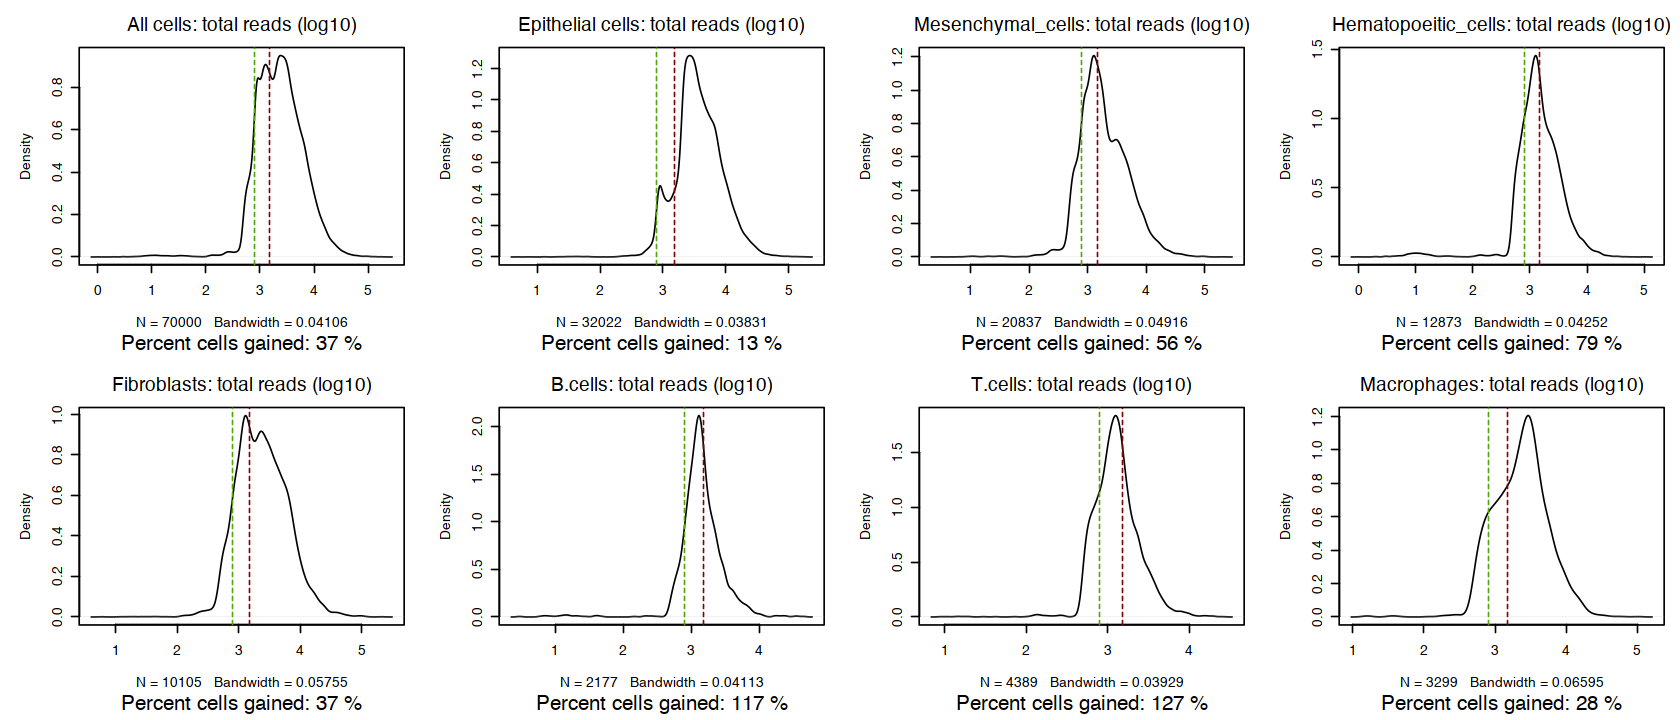

In [307]:

options(repr.plot.width=14, repr.plot.height=6)

title.size <- 1.4
lab.size <- 1.0
sub.size <- 1.4


## Plot number of reads and genes by lineage
par(mfrow=c(2,4), mar=c(6,5,3,1))

plot(main = "All cells: total reads (log10)", density(log10(meta_sub$nCount_RNA)), , cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.all/pre.retained.all),'%' ))  # subtitle

plot(main = "Epithelial cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[epi.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.epi/pre.retained.epi),'%' ))  # subtitle

plot(main = "Mesenchymal_cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[mes.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.mes/pre.retained.mes),'%' ))  # subtitle

plot(main = "Hematopoeitic_cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[hem.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.hem/pre.retained.hem),'%' ))  # subtitle

plot(main = "Fibroblasts: total reads (log10)", density(log10(meta_sub$nCount_RNA[fibro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.fibro/pre.retained.fibro),'%' ))  # subtitle

plot(main = "B.cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[bcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.bcell/pre.retained.bcell),'%' ))  # subtitle

plot(main = "T.cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[tcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.tcell/pre.retained.tcell),'%' ))  # subtitle

plot(main = "Macrophages: total reads (log10)", density(log10(meta_sub$nCount_RNA[macro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.macro/pre.retained.macro),'%' ))  # subtitle

# dev.off()


